In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time

In [2]:
model = models.vgg16(pretrained=True)
print(model)

c:\Users\WINDOWS\miniconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\WINDOWS\miniconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Replace the final full conected layer
num_fea = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_fea, 2)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), #Random flip by horizontal view
    transforms.RandomRotation(10), #Turn random about 10 degree    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(
    root='data1/train',
    transform=transform)

val_data = datasets.ImageFolder(
    root='data1/val', 
    transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=1e-4)
writer = SummaryWriter('runs/vgg16_experiment') 

In [6]:
dummy_input = torch.randn(1, 3, 224, 224)
writer.add_graph(model, dummy_input)

In [7]:
num_epochs = 15

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_loss, epoch)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images, labels
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    writer.add_scalar('Accuracy/val', accuracy, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Acc: {accuracy:.2f}%")

Epoch [1/15] | Loss: 0.8575 | Val Acc: 75.00%
Epoch [2/15] | Loss: 0.5817 | Val Acc: 75.00%
Epoch [3/15] | Loss: 0.6185 | Val Acc: 75.00%
Epoch [4/15] | Loss: 0.5287 | Val Acc: 75.00%
Epoch [5/15] | Loss: 0.6646 | Val Acc: 75.00%
Epoch [6/15] | Loss: 0.4356 | Val Acc: 75.00%
Epoch [7/15] | Loss: 0.5235 | Val Acc: 75.00%
Epoch [8/15] | Loss: 0.4536 | Val Acc: 75.00%
Epoch [9/15] | Loss: 0.5305 | Val Acc: 75.00%
Epoch [10/15] | Loss: 0.3909 | Val Acc: 75.00%
Epoch [11/15] | Loss: 0.4044 | Val Acc: 100.00%
Epoch [12/15] | Loss: 0.4183 | Val Acc: 100.00%
Epoch [13/15] | Loss: 0.2548 | Val Acc: 100.00%
Epoch [14/15] | Loss: 0.3641 | Val Acc: 100.00%
Epoch [15/15] | Loss: 0.2552 | Val Acc: 100.00%


In [8]:
from torchvision.utils import make_grid
images, labels = next(iter(val_loader))
img_grid = make_grid(images[:4])
writer.add_image('Sample Predictions', img_grid)

In [9]:
torch.save(model.state_dict(), 'model1.pth') #Save only the model's parameters
torch.save(model, 'full_model1.pth')

In [10]:
from torchvision import datasets, transforms

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(
    root='data1/test', 
    transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [11]:
model_eval = models.vgg16(weights=None)
num_features = model_eval.classifier[6].in_features
model_eval.classifier[6] = nn.Linear(num_features, 2)

In [12]:
model_eval.load_state_dict(torch.load('model1.pth')) 
model_eval.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
model_eval.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_eval(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f'Accuracy on test set: {test_acc:.2f}%')


Accuracy on test set: 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2763936..1.3494118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.7677125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.5324184].


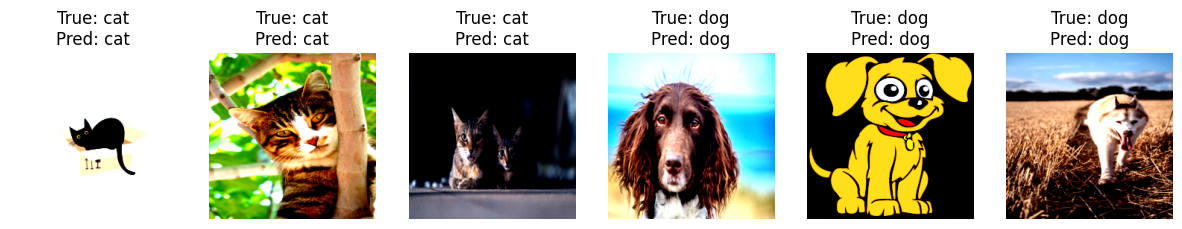

In [14]:
import matplotlib.pyplot as plt
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = model(images)
_, preds = torch.max(outputs, 1)

class_names = test_loader.dataset.classes

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for i in range(len(images)):
    ax = axes[i]
    img = images[i] / 2 + 0.5  # unnormalize nếu bạn normalize ở bước preprocess
    npimg = img.numpy().transpose((1, 2, 0))
    ax.imshow(npimg)
    ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
    ax.axis('off')

plt.show()


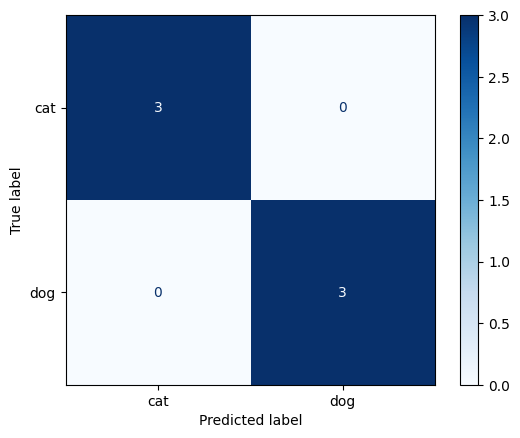

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
disp.plot(cmap='Blues')
plt.show()
